#### Phase 1 — High-Granularity Audit: derivatives_clean.parquet

Validates:
1) Calendar & Expiry Flags (weekly/monthly, ranking, expiry-day rows)
2) Instrument Physicality (FUT strike, moneyness polarity, basis spikes)
3) Enrichment Integrity (VIX variation, rates scaling/monotonicity, lot sizes via lot_size_map.parquet)
4) Data Density (strike holes around ATM ±10 strikes on 5 deterministic dates)

Notebook fails fast via AssertionError when invariants break.


In [10]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists() or (p / "data").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())

# derivatives_clean.parquet is in curated
PARQUET_PATH = REPO_ROOT / "data" / "curated" / "derivatives_clean.parquet"

# lot_size_map.parquet is in processed
LOT_MAP_PATH = REPO_ROOT / "data" / "processed" / "lot_size_map.parquet"

RANDOM_SEED = 42
DENSITY_NUM_DATES = 5
DENSITY_STRIKES_EACH_SIDE = 10

BASIS_SPIKE_FRAC = 0.02
BASIS_SPIKE_RATE_MAX = 0.02
MAX_REASONABLE_RATE = 1.0

UNIQUE_CONTRACT_KEY = [
    "date", "symbol", "instrument", "expiry_dt", "option_typ", "strike_pr"
]

print("cwd:", Path.cwd())
print("repo_root:", REPO_ROOT)
print("derivatives parquet:", PARQUET_PATH, "| exists:", PARQUET_PATH.exists())
print("lot map parquet:", LOT_MAP_PATH, "| exists:", LOT_MAP_PATH.exists())


cwd: /Users/priyamverma/Documents/GitHub/indian-index-derivatives-risk-lab/notebooks
repo_root: /Users/priyamverma/Documents/GitHub/indian-index-derivatives-risk-lab
derivatives parquet: /Users/priyamverma/Documents/GitHub/indian-index-derivatives-risk-lab/data/curated/derivatives_clean.parquet | exists: True
lot map parquet: /Users/priyamverma/Documents/GitHub/indian-index-derivatives-risk-lab/data/processed/lot_size_map.parquet | exists: True


In [11]:
if not PARQUET_PATH.exists():
    curated_dir = REPO_ROOT / "data" / "curated"
    print("data/curated exists:", curated_dir.exists())
    if curated_dir.exists():
        print("Top-level under data/curated/:", sorted([p.name for p in curated_dir.iterdir()]))
    raise FileNotFoundError(f"Could not find parquet at: {PARQUET_PATH}")

df = pd.read_parquet(PARQUET_PATH)

# Normalize datetimes
for c in ["date", "timestamp", "expiry_dt", "opt_weekly_expiry", "opt_monthly_expiry"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce").dt.normalize()

# Normalize strings
for c in ["symbol", "instrument"]:
    if c in df.columns:
        df[c] = df[c].astype(str)

# option_typ can be null for futures
if "option_typ" in df.columns:
    df["option_typ"] = df["option_typ"].where(df["option_typ"].notna(), None)
    df["option_typ"] = df["option_typ"].apply(lambda x: x if x is None else str(x).strip())

print("rows:", len(df), "cols:", df.shape[1])
df.head(3)

rows: 5808433 cols: 33


,date,timestamp,symbol,instrument,expiry_dt,expiry_rank,strike_pr,option_typ,open,high,low,close,settle_pr,contracts,open_int,chg_in_oi,spot_close,vix_close,div_yield,lot_size,end_date,rate_91d,rate_182d,rate_364d,cal_days_to_expiry,trading_days_to_expiry,opt_weekly_expiry,opt_monthly_expiry,is_trade_calendar_date,is_trading_day,is_opt_weekly_expiry,is_opt_monthly_expiry,moneyness
0,2019-07-01,2019-07-01,BANKNIFTY,FUTIDX,2019-07-25,1,0.0,XX,31400.25,31559.85,31351.15,31496.3,31496.3,84768.0,1702140.0,17800.0,31372.2,14.6,0.0040,20,2020-05-03,0.0598,0.0612,0.0616,24,18,2019-07-04,2019-07-25,True,True,False,True,NaN
1,2019-07-01,2019-07-01,NIFTY,FUTIDX,2019-09-26,3,0.0,XX,11985.00,12025.00,11973.50,12005.1,12005.1,210.0,18150.0,4650.0,11865.6,14.6,0.0123,75,2021-04-29,0.0598,0.0612,0.0616,87,59,2019-07-04,2019-07-25,True,True,False,False,NaN
2,2019-07-01,2019-07-01,NIFTY,OPTIDX,2019-07-04,1,9650.0,CE,0.00,0.00,0.00,2200.0,2220.6,0.0,0.0,0.0,11865.6,14.6,0.0123,75,2021-04-29,0.0598,0.0612,0.0616,3,3,2019-07-04,2019-07-25,True,True,True,False,2215.6


In [12]:
def require_columns(df_: pd.DataFrame, cols: list[str]) -> None:
    missing = [c for c in cols if c not in df_.columns]
    if missing:
        raise AssertionError(f"Missing required columns: {missing}")

require_columns(df, [
    "date","symbol","instrument","expiry_dt","expiry_rank","strike_pr","spot_close","settle_pr",
    "cal_days_to_expiry","rate_91d","rate_364d","vix_close",
    "lot_size","is_opt_weekly_expiry","is_opt_monthly_expiry","option_typ"
])

min_dte = int(df["cal_days_to_expiry"].min())
assert min_dte >= 0, f"Negative Time: min(cal_days_to_expiry)={min_dte} < 0"

max_rate = float(df[["rate_91d","rate_364d"]].max().max())
assert max_rate < MAX_REASONABLE_RATE, f"Rate Scaling: max rate={max_rate} >= {MAX_REASONABLE_RATE} (rates should be decimals)"

print("OK: required columns, non-negative time, rate scaling")


OK: required columns, non-negative time, rate scaling


In [13]:
require_columns(df, UNIQUE_CONTRACT_KEY)

dup_mask = df.duplicated(UNIQUE_CONTRACT_KEY, keep=False)
dup_df = df.loc[dup_mask, UNIQUE_CONTRACT_KEY].sort_values(UNIQUE_CONTRACT_KEY)

assert dup_df.empty, (
    f"Holiday Drift / join duplication: found {len(dup_df)} duplicated rows "
    f"by unique contract key {UNIQUE_CONTRACT_KEY}. Example:\n{dup_df.head(30)}"
)

print("OK: no duplicates by unique contract key")

OK: no duplicates by unique contract key


In [ ]:
# Monthly expiry validation using futures expiry dates:
# Logic: for each symbol and each expiry-month, there should be exactly one monthly FUTIDX expiry date.
# Derive "expiry events" from FUTIDX rows on expiry day (cal_days_to_expiry == 0),
# then count unique expiry_dt per (symbol, year, month).

# Basic diagnostics for flags (do not assert counts at row level)
weekly_row_ct = int((df["is_opt_weekly_expiry"] == True).sum())
monthly_row_ct = int((df["is_opt_monthly_expiry"] == True).sum())
print("Weekly expiry rows (raw):", weekly_row_ct)
print("Monthly expiry rows (raw):", monthly_row_ct)

both = df[(df["is_opt_weekly_expiry"] == True) & (df["is_opt_monthly_expiry"] == True)]
assert both.empty, (
    "Weekly+Monthly both True on same row(s). Sample:\n"
    f"{both[UNIQUE_CONTRACT_KEY].head(20)}"
)

# FUTIDX expiry-day rows define actual monthly futures expiries present in the dataset
fut_exp = df[(df["instrument"] == "FUTIDX") & (df["cal_days_to_expiry"] == 0)].copy()
assert not fut_exp.empty, "No FUTIDX expiry-day rows found (instrument=FUTIDX & cal_days_to_expiry==0)."

# On expiry day, the expiring contract should be the near contract; enforce for cleanliness
if "expiry_rank" in fut_exp.columns:
    bad_rank = fut_exp[fut_exp["expiry_rank"] != 1][["date", "symbol", "expiry_dt", "expiry_rank"]].head(50)
    assert bad_rank.empty, (
        "FUTIDX expiry-day rows should have expiry_rank==1. Sample violations:\n"
        f"{bad_rank}"
    )

# Unique expiry events: one per symbol per expiry_dt
fut_events = fut_exp[["symbol", "expiry_dt"]].dropna().drop_duplicates().copy()
fut_events["year"] = fut_events["expiry_dt"].dt.year
fut_events["month"] = fut_events["expiry_dt"].dt.month

# Exactly 1 expiry_dt per (symbol, year, month) (this is the core rule you stated)
per_month = (
    fut_events.groupby(["symbol", "year", "month"])["expiry_dt"]
    .nunique()
    .rename("monthly_future_expiry_events")
    .reset_index()
    .sort_values(["symbol", "year", "month"])
)
display(per_month.head(60))

bad_month = per_month[per_month["monthly_future_expiry_events"] != 1]
assert bad_month.empty, (
    "Expected exactly 1 monthly FUTIDX expiry date per (symbol, year, month). Violations:\n"
    f"{bad_month.head(100)}"
)

# Now roll up to year: count months with an expiry event
per_year = (
    fut_events.groupby(["symbol", "year"])["month"]
    .nunique()
    .rename("months_with_monthly_future_expiry")
    .reset_index()
    .sort_values(["symbol", "year"])
)
display(per_year)

# Determine which years are "complete trading years" in the dataset (12 calendar months present in trade dates)
df_dates = df[["symbol", "date"]].dropna().copy()
df_dates["year"] = pd.to_datetime(df_dates["date"]).dt.year
df_dates["month"] = pd.to_datetime(df_dates["date"]).dt.month
months_present = (
    df_dates.groupby(["symbol", "year"])["month"]
    .nunique()
    .rename("trade_months_present")
    .reset_index()
)

per_year_chk = per_year.merge(months_present, on=["symbol", "year"], how="left")

# Assert: if the dataset has 12 trade months present for that symbol/year, we expect 12 monthly futures expiries
complete_years = per_year_chk[per_year_chk["trade_months_present"] == 12].copy()
bad_complete = complete_years[complete_years["months_with_monthly_future_expiry"] != 12].copy()

if not bad_complete.empty:
    # Helpful debug: show which expiry months are missing
    missing_rows = []
    for _, r in bad_complete.iterrows():
        sym = r["symbol"]
        yr = int(r["year"])
        have_months = sorted(fut_events[(fut_events["symbol"] == sym) & (fut_events["year"] == yr)]["month"].unique().tolist())
        missing = [m for m in range(1, 13) if m not in have_months]
        missing_rows.append({"symbol": sym, "year": yr, "missing_expiry_months": missing, "have_months": have_months})
    missing_df = pd.DataFrame(missing_rows)
    display(bad_complete)
    display(missing_df)
    raise AssertionError(
        "Expected 12 monthly FUTIDX expiry months for complete trade years (12 trade months present). "
        "Missing expiry months detected; see tables above."
    )

print("OK: monthly futures expiry logic validated (1 per month; 12 per complete trade year)")


Weekly expiry rows (raw): 573302
Monthly expiry rows (raw): 701632


,symbol,year,month,monthly_future_expiry_events
0,BANKNIFTY,2019,7,1
1,BANKNIFTY,2019,8,1
2,BANKNIFTY,2019,9,1
3,BANKNIFTY,2019,10,1
4,BANKNIFTY,2019,11,1
5,BANKNIFTY,2019,12,1
6,BANKNIFTY,2020,1,1
7,BANKNIFTY,2020,2,1
8,BANKNIFTY,2020,3,1
9,BANKNIFTY,2020,4,1


,symbol,year,months_with_monthly_future_expiry
0,BANKNIFTY,2019,6
1,BANKNIFTY,2020,12
2,BANKNIFTY,2021,12
3,BANKNIFTY,2022,12
4,BANKNIFTY,2023,12
5,BANKNIFTY,2024,12
6,BANKNIFTY,2025,11
7,NIFTY,2019,6
8,NIFTY,2020,12
9,NIFTY,2021,12


,symbol,year,months_with_monthly_future_expiry,trade_months_present
6,BANKNIFTY,2025,11,12
13,NIFTY,2025,11,12


,symbol,year,missing_expiry_months,have_months
0,BANKNIFTY,2025,[12],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
1,NIFTY,2025,[12],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"


AssertionError: Expected 12 monthly FUTIDX expiry months for complete trade years (12 trade months present). Missing expiry months detected; see tables above.

In [17]:
gcols = ["date", "symbol", "instrument"]

min_exp = df.groupby(gcols)["expiry_dt"].min().rename("min_expiry_dt").reset_index()
rank1 = df[df["expiry_rank"] == 1][gcols + ["expiry_dt"]].drop_duplicates()

chk = rank1.merge(min_exp, on=gcols, how="left")
bad = chk[chk["expiry_dt"] != chk["min_expiry_dt"]]

assert bad.empty, f"expiry_rank==1 is not near contract for some groups. Sample:\n{bad.head(50)}"
print("OK: expiry_rank==1 matches near expiry for all (date,symbol,instrument)")


OK: expiry_rank==1 matches near expiry for all (date,symbol,instrument)


In [18]:
exp0 = df[df["cal_days_to_expiry"] == 0].copy()
assert not exp0.empty, "Expected cal_days_to_expiry==0 rows (expiry-day) but found none."

bad = exp0[exp0["date"] != exp0["expiry_dt"]]
assert bad.empty, f"Expiry-day coherence broken: cal_days_to_expiry==0 but date!=expiry_dt. Sample:\n{bad.head(50)}"

missing_settle = int(exp0["settle_pr"].isna().sum())
assert missing_settle == 0, f"Expiry-day has missing settle_pr rows: {missing_settle}"

if "close" in exp0.columns:
    missing_close = int(exp0["close"].isna().sum())
    assert missing_close == 0, f"Expiry-day has missing close rows: {missing_close}"

sample_cols = ["date","symbol","instrument","expiry_dt","settle_pr","close","spot_close","strike_pr","option_typ"]
sample_cols = [c for c in sample_cols if c in exp0.columns]
display(exp0[sample_cols].head(50))

print("OK: expiry-day rows present and coherent")

,date,symbol,instrument,expiry_dt,settle_pr,close,spot_close,strike_pr,option_typ
13093,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,1047.00,11946.75,13000.0,PE
13094,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,1176.90,11946.75,13050.0,PE
13095,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,1155.00,11946.75,13100.0,PE
13121,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,1272.35,11946.75,13150.0,PE
13122,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,0.05,11946.75,11750.0,PE
13123,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,0.05,11946.75,11650.0,PE
13124,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,0.05,11946.75,11600.0,PE
13125,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,0.10,11946.75,11550.0,PE
13126,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,724.45,11946.75,12550.0,PE
13127,2019-07-04,NIFTY,OPTIDX,2019-07-04,0.0,767.00,11946.75,12600.0,PE


OK: expiry-day rows present and coherent


In [19]:
fut = df[df["instrument"] == "FUTIDX"]
if fut.empty:
    print("WARN: No FUTIDX rows found")
else:
    bad_fut = fut[fut["strike_pr"] != 0.0][["date","symbol","expiry_dt","strike_pr"]].head(50)
    assert bad_fut.empty, f"FUTIDX physicality violated (strike_pr != 0). Sample:\n{bad_fut}"
    print("OK: FUTIDX strike_pr==0.0")

opt = df[df["instrument"] == "OPTIDX"].copy()
if opt.empty:
    print("WARN: No OPTIDX rows found")
else:
    ce = opt[opt["option_typ"] == "CE"].copy()
    pe = opt[opt["option_typ"] == "PE"].copy()

    ce_sign = np.sign(ce["spot_close"] - ce["strike_pr"])
    pe_sign = np.sign(pe["strike_pr"] - pe["spot_close"])

    ce_bad = ce[(ce["moneyness"].abs() > 1e-12) & (np.sign(ce["moneyness"]) != ce_sign)]
    pe_bad = pe[(pe["moneyness"].abs() > 1e-12) & (np.sign(pe["moneyness"]) != pe_sign)]

    assert ce_bad.empty, f"Moneyness polarity failed for CE. Sample:\n{ce_bad[['date','symbol','expiry_dt','spot_close','strike_pr','moneyness']].head(50)}"
    assert pe_bad.empty, f"Moneyness polarity failed for PE. Sample:\n{pe_bad[['date','symbol','expiry_dt','spot_close','strike_pr','moneyness']].head(50)}"

    print("OK: moneyness polarity matches CE/PE rules")

OK: FUTIDX strike_pr==0.0
OK: moneyness polarity matches CE/PE rules


Near futures rows: 3190
Basis spikes: 0


,date,symbol,expiry_dt,settle_pr,spot_close,basis,basis_abs_frac


,symbol,spike_rate
0,BANKNIFTY,0.0
1,NIFTY,0.0


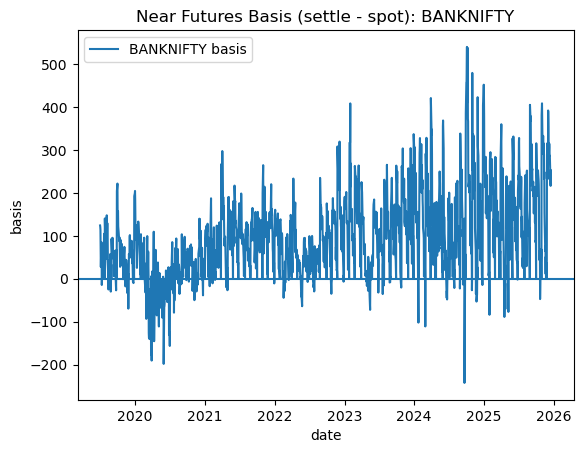

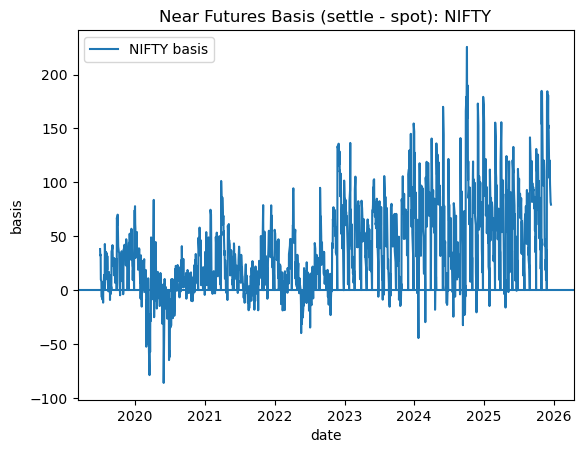

OK: basis checks and plots


In [20]:
near_fut = df[(df["instrument"] == "FUTIDX") & (df["expiry_rank"] == 1)].copy()
assert not near_fut.empty, "No near futures found (instrument=FUTIDX & expiry_rank=1)."

near_fut["basis"] = near_fut["settle_pr"] - near_fut["spot_close"]
near_fut["basis_abs_frac"] = near_fut["basis"].abs() / near_fut["spot_close"].replace(0.0, np.nan)
near_fut["is_basis_spike"] = near_fut["basis_abs_frac"] > BASIS_SPIKE_FRAC

spikes = near_fut[near_fut["is_basis_spike"]].copy()
print("Near futures rows:", len(near_fut))
print("Basis spikes:", len(spikes))
display(spikes[["date","symbol","expiry_dt","settle_pr","spot_close","basis","basis_abs_frac"]].sort_values(["symbol","date"]).head(50))

spike_rate = (
    near_fut.drop_duplicates(["date","symbol","expiry_dt"])
    .groupby("symbol")["is_basis_spike"]
    .mean()
    .rename("spike_rate")
    .reset_index()
)
display(spike_rate.sort_values("spike_rate", ascending=False))

bad_rate = spike_rate[spike_rate["spike_rate"] > BASIS_SPIKE_RATE_MAX]
assert bad_rate.empty, f"Basis spikes too frequent (> {BASIS_SPIKE_RATE_MAX:.2%}) for:\n{bad_rate}"

for sym, g in near_fut.groupby("symbol"):
    g = g.sort_values("date")
    plt.figure()
    plt.plot(g["date"], g["basis"], label=f"{sym} basis")
    plt.axhline(0.0)
    plt.title(f"Near Futures Basis (settle - spot): {sym}")
    plt.xlabel("date")
    plt.ylabel("basis")
    plt.legend()
    plt.show()

print("OK: basis checks and plots")


In [23]:
# Treasury curve monotonicity should be evaluated at symbol-date grain (not contract/strike grain),
# because rates are expected to be identical across contracts on the same day.

rate_cols = ["rate_91d", "rate_364d"]
require_columns(df, ["date", "symbol"] + rate_cols)

# Deduplicate to one row per (symbol, date) so we don't inflate counts via strikes/contracts
rate_sym_date = (
    df[["date", "symbol"] + rate_cols]
    .dropna(subset=["date", "symbol"])
    .drop_duplicates(["date", "symbol"])
    .copy()
)

rate_sym_date["is_curve_violation"] = rate_sym_date["rate_364d"] < rate_sym_date["rate_91d"]

viol = rate_sym_date[rate_sym_date["is_curve_violation"]].copy()
print("Monotonicity violations (symbol-date) rate_364d < rate_91d:", len(viol))
display(viol.sort_values(["symbol", "date"]).head(50))

# Violation rate per symbol using symbol-date denominator
tot = rate_sym_date.groupby("symbol").size().rename("symbol_date_n")
v = viol.groupby("symbol").size().rename("viol_symbol_date_n")
summary = pd.concat([tot, v], axis=1).fillna(0)
summary["viol_rate"] = summary["viol_symbol_date_n"] / summary["symbol_date_n"]
display(summary.reset_index().sort_values("viol_rate", ascending=False))

# Optional additional view: if rates truly identical across symbols too, evaluate once per date
rate_date = (
    df[["date"] + rate_cols]
    .dropna(subset=["date"])
    .drop_duplicates(["date"])
    .copy()
)
rate_date["is_curve_violation"] = rate_date["rate_364d"] < rate_date["rate_91d"]
viol_date = rate_date[rate_date["is_curve_violation"]].copy()
print("Monotonicity violations (date-only):", len(viol_date))
display(viol_date.sort_values(["date"]).head(50))

# VIX variability check per symbol
require_columns(df, ["vix_close"])
vix_by_sym = df.groupby("symbol")["vix_close"].agg(["std", "min", "max", "count"]).reset_index()
display(vix_by_sym.sort_values("std").head(20))

bad_vix = vix_by_sym[vix_by_sym["std"].fillna(0.0) <= 1e-6]
assert bad_vix.empty, f"VIX appears constant/zero for:\n{bad_vix}"

print("OK: curve violations quantified at symbol-date (and date-only) grain; VIX varies")


Monotonicity violations (symbol-date) rate_364d < rate_91d: 64


,date,symbol,rate_91d,rate_364d,is_curve_violation
846750,2020-03-24,BANKNIFTY,0.0505,0.04983,True
857059,2020-03-25,BANKNIFTY,0.0505,0.04983,True
4040202,2023-05-10,BANKNIFTY,0.0695,0.06924,True
4042952,2023-05-11,BANKNIFTY,0.0695,0.06914,True
4045612,2023-05-12,BANKNIFTY,0.0695,0.06906,True
4048239,2023-05-15,BANKNIFTY,0.0695,0.06893,True
4051676,2023-05-16,BANKNIFTY,0.0691,0.06871,True
4054993,2023-05-17,BANKNIFTY,0.0687,0.06827,True
4116783,2023-06-20,BANKNIFTY,0.0681,0.06801,True
4528945,2024-02-01,BANKNIFTY,0.0704,0.07016,True


,symbol,symbol_date_n,viol_symbol_date_n,viol_rate
0,BANKNIFTY,1595,32,0.020063
1,NIFTY,1595,32,0.020063


Monotonicity violations (date-only): 32


,date,rate_91d,rate_364d,is_curve_violation
846750,2020-03-24,0.0505,0.04983,True
855416,2020-03-25,0.0505,0.04983,True
4040200,2023-05-10,0.0695,0.06924,True
4042899,2023-05-11,0.0695,0.06914,True
4045612,2023-05-12,0.0695,0.06906,True
4048239,2023-05-15,0.0695,0.06893,True
4050898,2023-05-16,0.0691,0.06871,True
4053613,2023-05-17,0.0687,0.06827,True
4116460,2023-06-20,0.0681,0.06801,True
4528945,2024-02-01,0.0704,0.07016,True


,symbol,std,min,max,count
0,BANKNIFTY,9.367813,9.84,83.61,2487449
1,NIFTY,9.785943,9.84,83.61,3320984


OK: curve violations quantified at symbol-date (and date-only) grain; VIX varies


Sample dates: [Timestamp('2020-12-16 00:00:00'), Timestamp('2023-03-15 00:00:00'), Timestamp('2024-01-12 00:00:00'), Timestamp('2024-09-05 00:00:00'), Timestamp('2025-07-09 00:00:00')]


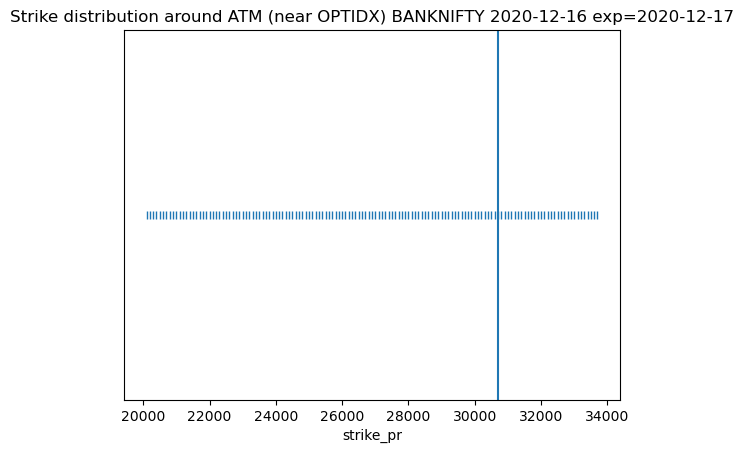

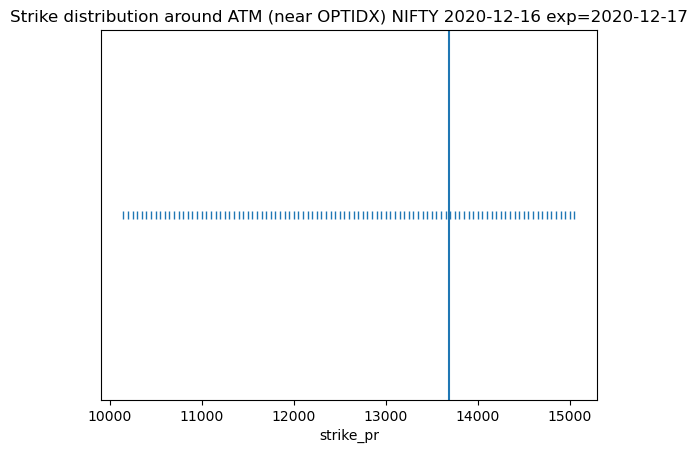

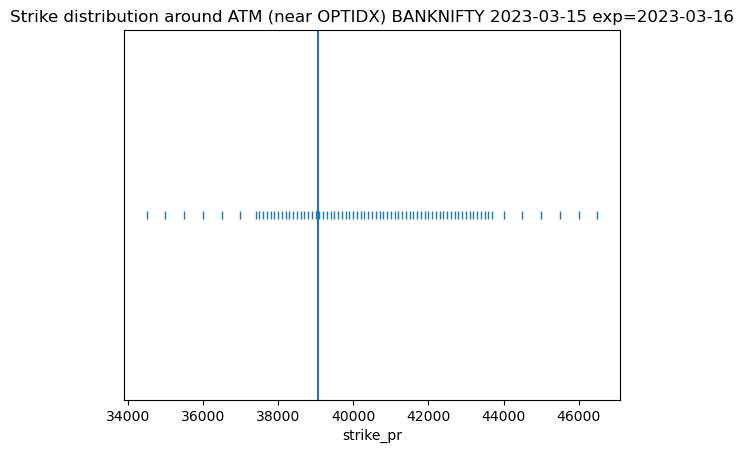

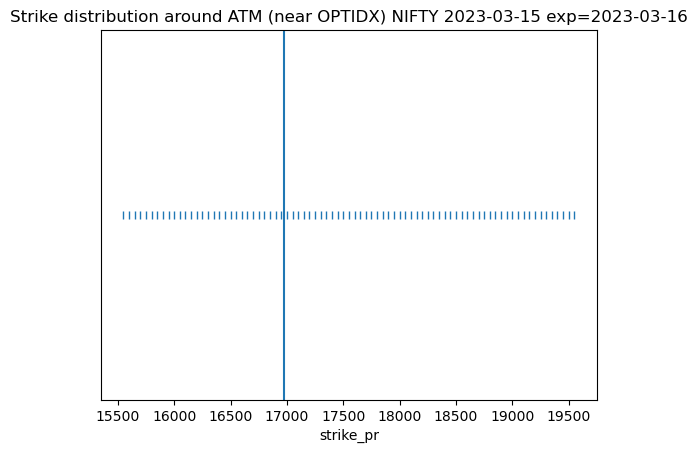

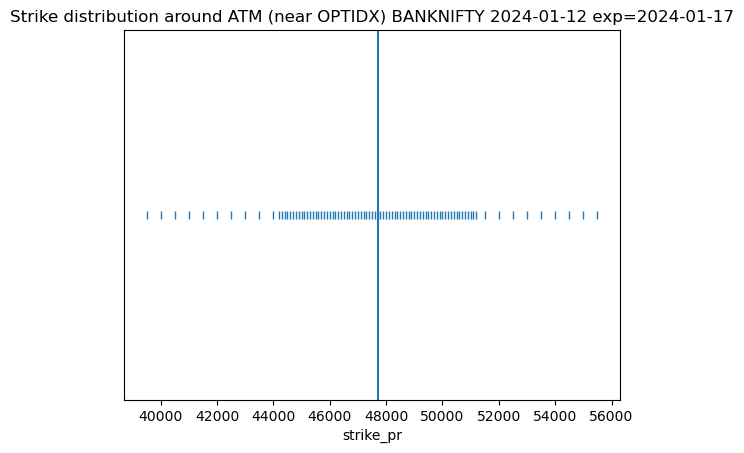

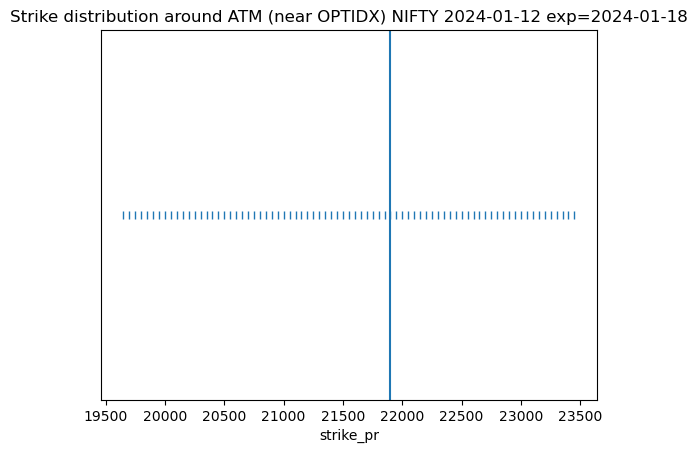

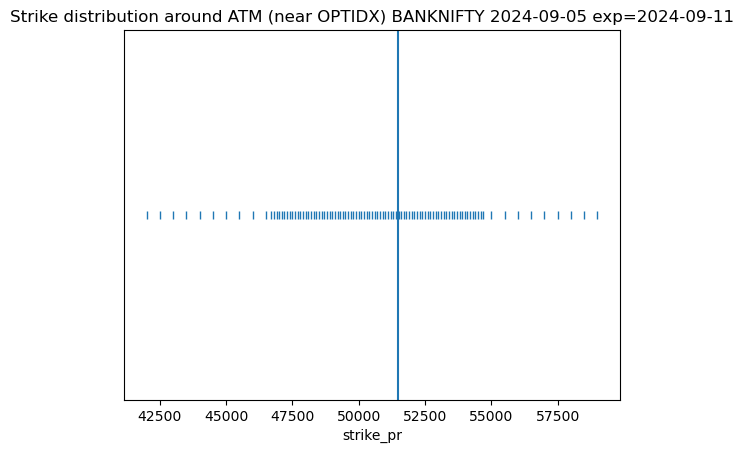

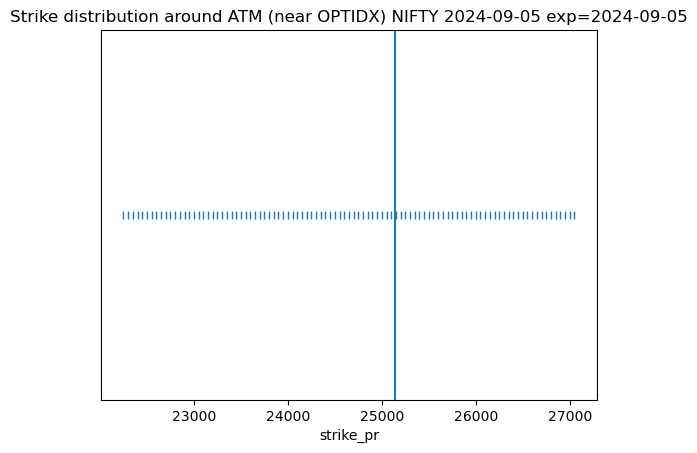

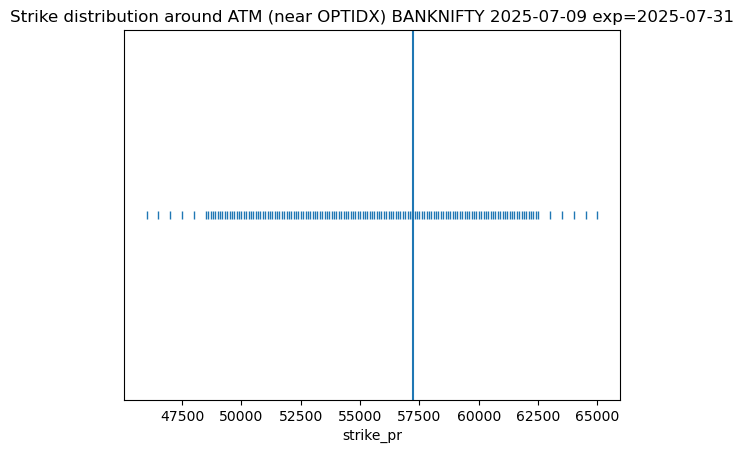

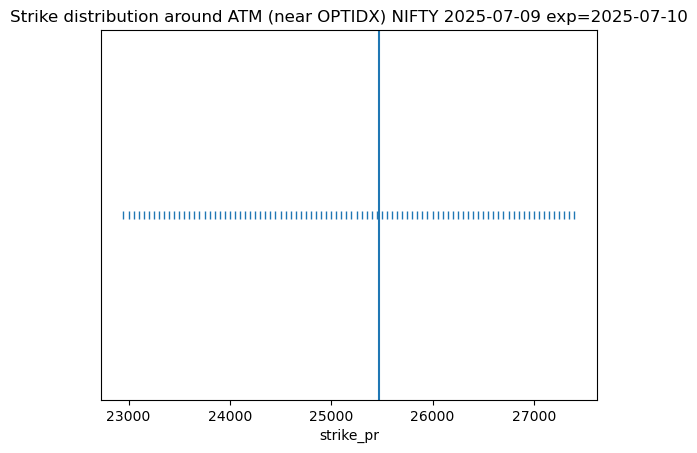

,date,symbol,expiry_dt,spot_close,atm_strike,inferred_step,expected_strikes,observed_strikes_total,missing_in_atm_window,missing_strikes_sample
0,2020-12-16,BANKNIFTY,2020-12-17,30698.40,30700.0,100.0,21,137,0,[]
1,2020-12-16,NIFTY,2020-12-17,13682.70,13700.0,50.0,21,99,0,[]
2,2023-03-15,BANKNIFTY,2023-03-16,39051.50,39100.0,100.0,21,76,0,[]
3,2023-03-15,NIFTY,2023-03-16,16972.15,16950.0,50.0,21,81,0,[]
4,2024-01-12,BANKNIFTY,2024-01-17,47709.80,47700.0,100.0,21,90,0,[]
5,2024-01-12,NIFTY,2024-01-18,21894.55,21900.0,50.0,21,77,0,[]
6,2024-09-05,BANKNIFTY,2024-09-11,51473.05,51500.0,100.0,21,100,0,[]
7,2024-09-05,NIFTY,2024-09-05,25145.10,25150.0,50.0,21,97,0,[]
8,2025-07-09,BANKNIFTY,2025-07-31,57213.55,57200.0,100.0,21,151,0,[]
9,2025-07-09,NIFTY,2025-07-10,25476.10,25500.0,50.0,21,90,0,[]


OK: strike density summary produced


In [24]:
def infer_strike_step(strikes: np.ndarray) -> float | None:
    strikes = np.array(sorted(set(float(x) for x in strikes if pd.notna(x) and float(x) > 0)))
    if len(strikes) < 3:
        return None
    diffs = np.diff(strikes)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return None
    return float(pd.Series(diffs).round(6).mode().iloc[0])

dates = sorted(pd.to_datetime(df["date"]).dropna().unique().tolist())
rng = np.random.RandomState(RANDOM_SEED)
k = min(DENSITY_NUM_DATES, len(dates))
sample_idx = sorted(rng.choice(len(dates), size=k, replace=False))
sample_dates = [pd.to_datetime(dates[i]).normalize() for i in sample_idx]

print("Sample dates:", sample_dates)

density_rows = []
for d in sample_dates:
    day = df[pd.to_datetime(df["date"]).dt.normalize() == pd.to_datetime(d).normalize()].copy()
    day = day[(day["instrument"] == "OPTIDX") & (day["expiry_rank"] == 1)]
    if day.empty:
        continue

    for (sym, exp), g in day.groupby(["symbol", "expiry_dt"]):
        strikes = np.array(sorted(set(float(x) for x in g["strike_pr"].dropna().unique().tolist() if float(x) > 0)))
        if len(strikes) == 0:
            continue

        step = infer_strike_step(strikes)
        if step is None or step <= 0:
            continue

        spot = float(g["spot_close"].iloc[0])
        atm = float(strikes[np.argmin(np.abs(strikes - spot))])

        target = np.array([atm + i * step for i in range(-DENSITY_STRIKES_EACH_SIDE, DENSITY_STRIKES_EACH_SIDE + 1)])
        observed = set(np.round(strikes, 6))
        missing = [float(x) for x in np.round(target, 6) if float(x) not in observed]

        density_rows.append({
            "date": d,
            "symbol": sym,
            "expiry_dt": exp,
            "spot_close": spot,
            "atm_strike": atm,
            "inferred_step": step,
            "expected_strikes": len(target),
            "observed_strikes_total": len(strikes),
            "missing_in_atm_window": len(missing),
            "missing_strikes_sample": missing[:20],
        })

        plt.figure()
        plt.plot(strikes, np.zeros_like(strikes), marker="|", linestyle="")
        plt.axvline(spot)
        plt.title(
            f"Strike distribution around ATM (near OPTIDX) {sym} "
            f"{pd.to_datetime(d).date()} exp={pd.to_datetime(exp).date()}"
        )
        plt.xlabel("strike_pr")
        plt.yticks([])
        plt.show()

density = pd.DataFrame(density_rows).sort_values(["date", "symbol"])
display(density.head(200))

print("OK: strike density summary produced")
